PART 1: Data Preprocessing and Exploration



In [2]:
from google.colab import files
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Upload the dataset
uploaded = files.upload()

Saving 119 Heart.csv to 119 Heart.csv


Missing Values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
Data Description:
                age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610     0.942439   131.611707   246.00000   
std       9.072290     0.460373     1.029641    17.516718    51.59251   
min      29.000000     0.000000     0.000000    94.000000   126.00000   
25%      48.000000     0.000000     0.000000   120.000000   211.00000   
50%      56.000000     1.000000     1.000000   130.000000   240.00000   
75%      61.000000     1.000000     2.000000   140.000000   275.00000   
max      77.000000     1.000000     3.000000   200.000000   564.00000   

               fbs      restecg      thalach        exang      oldpeak  \
count  1025.000000  102

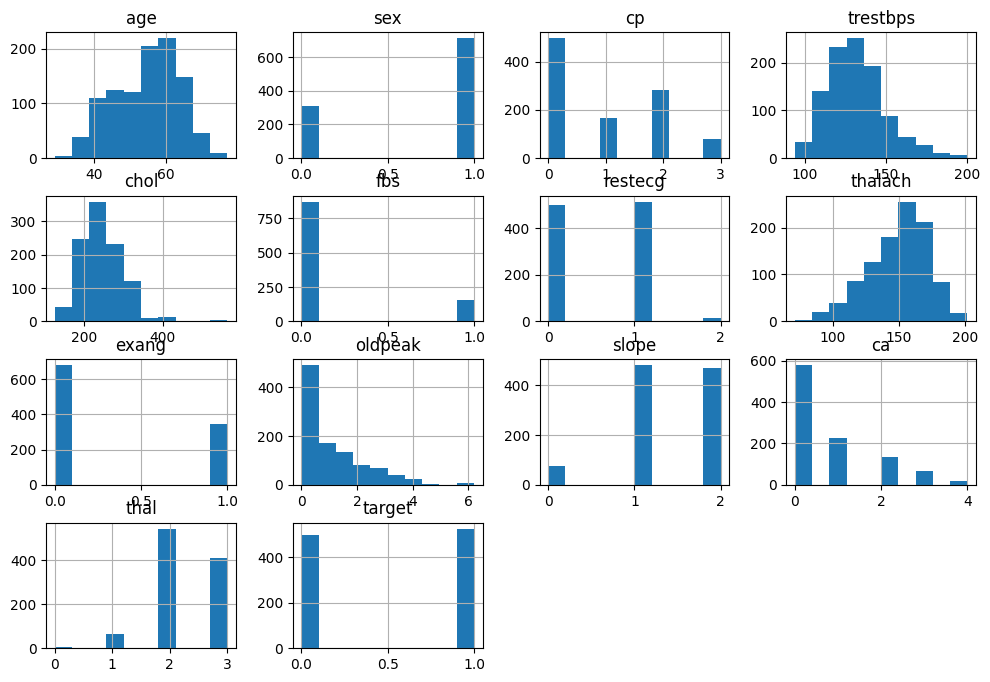

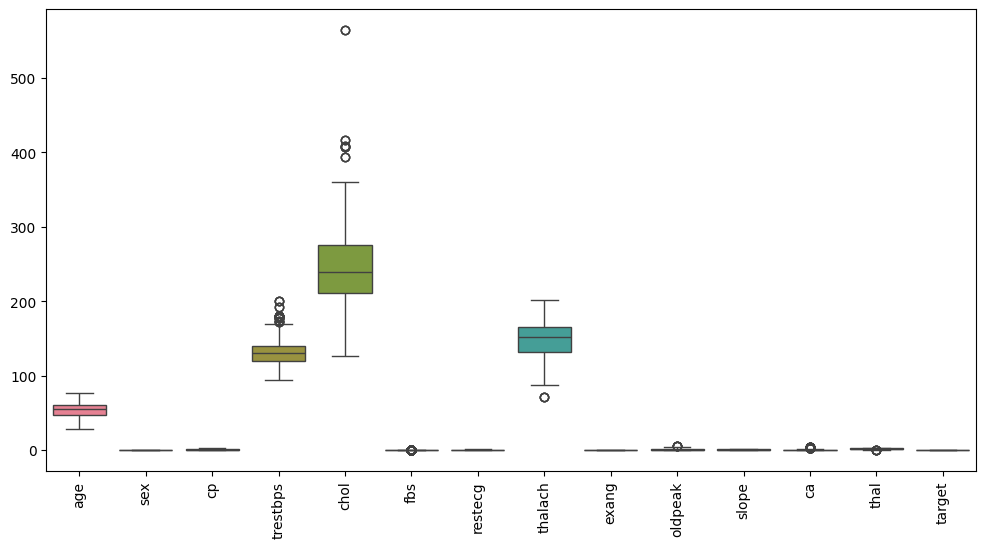

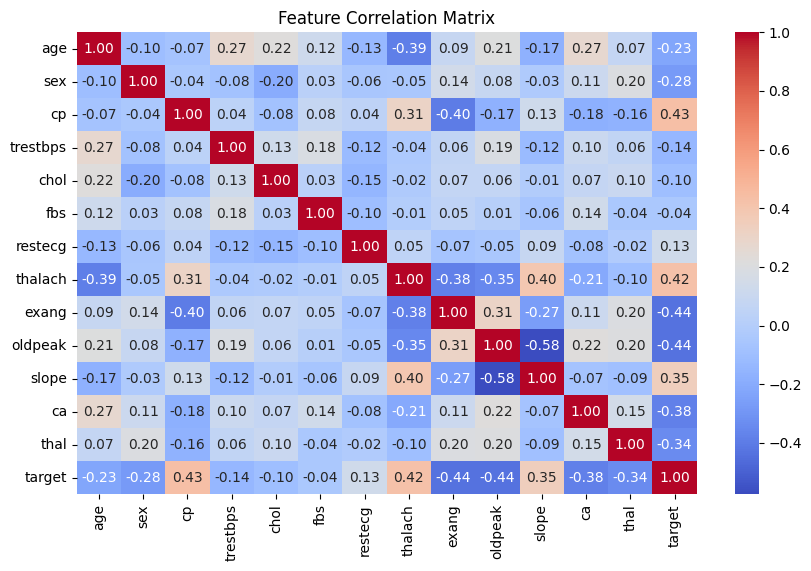

Outliers:
 age           0
sex           0
cp            0
trestbps     30
chol         16
fbs         153
restecg       0
thalach       4
exang         0
oldpeak       7
slope         0
ca           87
thal          7
target        0
dtype: int64
Standardized Data:
         age       sex        cp  trestbps      chol  fbs   restecg   thalach  \
0 -0.155300  0.667449 -0.907835 -0.240805 -0.675971  0.0  0.870574  0.768418   
2  1.797168  0.667449 -0.907835  1.066034 -1.530053  0.0  0.870574 -1.138183   
3  0.820934  0.667449 -0.907835  1.262060 -0.878254  0.0  0.870574  0.458041   
5  0.495523 -1.498241 -0.907835 -1.874354  0.133160  0.0 -1.069923 -1.271202   
7  0.170111  0.667449 -0.907835  2.046163  1.054670  0.0 -1.069923 -0.251392   

      exang   oldpeak     slope        ca      thal    target  
0 -0.691987  0.026266  0.952814  2.134054  1.175946 -1.102787  
2  1.445114  1.550693 -2.439380 -0.702744  1.175946 -1.102787  
3 -0.691987 -0.926501  0.952814  0.715655  1.175946 -1.1027

<ipython-input-3-719f2e5463fd>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols] = scaler.fit_transform(df[num_cols])


In [3]:
df = pd.read_csv('119 Heart.csv')

#check for missing values and basic statistics
print("Missing Values:\n", df.isnull().sum())
print("Data Description:\n", df.describe())

import matplotlib.pyplot as plt
import seaborn as sns
#histograms
df.hist(figsize=(12, 8))
plt.show()
#box plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()
#correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

#detect and remove outliers using IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = ((df < lower_bound) | (df > upper_bound)).sum()
print("Outliers:\n", outliers)
df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

#select numerical columns for scaling
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
print("Standardized Data:\n", df.head())

PART 2: Encoding and Initial Feature Selection


In [4]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
#encoding categorical variables
cat_cols = ["sex", "cp", "restecg", "exang"]
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_features = encoder.fit_transform(df[cat_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cat_cols))
df = df.drop(columns=cat_cols).reset_index(drop=True)
df = pd.concat([df, encoded_df], axis=1)
print("Data After Encoding:\n", df.head())

#remove highly correlated features
corr_matrix = df.corr()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.85)]
df = df.drop(columns=correlated_features)
print("Dropped Features Due to High Correlation:", correlated_features)
print("Data After Removing Correlated Features:\n", df.head())

#feature selection using mutual information
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler

# Reload dataset for feature selection
df = pd.read_csv("119 Heart.csv")
X = df.drop(columns=["target"])
y = df["target"]

# Normalize features for Chi-Square test
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
kbest = SelectKBest(score_func=chi2, k=10)
X_new_kbest = kbest.fit_transform(X_scaled, y)

# Apply Mutual Information for feature importance ranking
mutual_info = mutual_info_classif(X, y)
mutual_info_df = pd.DataFrame({"Feature": X.columns, "Score": mutual_info}).sort_values(by="Score", ascending=False)
selected_features = mutual_info_df["Feature"].head(10).tolist()
df_selected = df[selected_features + ["target"]]
print("Feature Importance Ranking:\n", mutual_info_df)
print("Dataset with Selected Features:\n", df_selected.head())

Data After Encoding:
         age  trestbps      chol  fbs   thalach   oldpeak     slope        ca  \
0 -0.155300 -0.240805 -0.675971  0.0  0.768418  0.026266  0.952814  2.134054   
1  1.797168  1.066034 -1.530053  0.0 -1.138183  1.550693 -2.439380 -0.702744   
2  0.820934  1.262060 -0.878254  0.0  0.458041 -0.926501  0.952814  0.715655   
3  0.495523 -1.874354  0.133160  0.0 -1.271202  0.026266 -0.743283 -0.702744   
4  0.170111  2.046163  1.054670  0.0 -0.251392 -0.164287 -0.743283  0.715655   

       thal    target  sex_0.6674494151653075  cp_0.07405686307070257  \
0  1.175946 -1.102787                     1.0                     0.0   
1  1.175946 -1.102787                     1.0                     0.0   
2  1.175946 -1.102787                     1.0                     0.0   
3 -0.583397  0.906794                     0.0                     0.0   
4  1.175946 -1.102787                     1.0                     0.0   

   cp_1.055948719990879  cp_2.0378405769110555  restecg_0.

PART 3: Initial Model Training and Evaluation


Class Distribution (Target):
target
1    0.513171
0    0.486829
Name: proportion, dtype: float64


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Performance:
Accuracy: 0.7902
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       100
           1       0.76      0.86      0.81       105

    accuracy                           0.79       205
   macro avg       0.80      0.79      0.79       205
weighted avg       0.79      0.79      0.79       205

Random Forest Performance:
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205

Model Comparison:
                  Model  Accuracy
0  Logistic Regression  0.790244
1        Random Forest  1.000000
Model saved as 119model.pkl


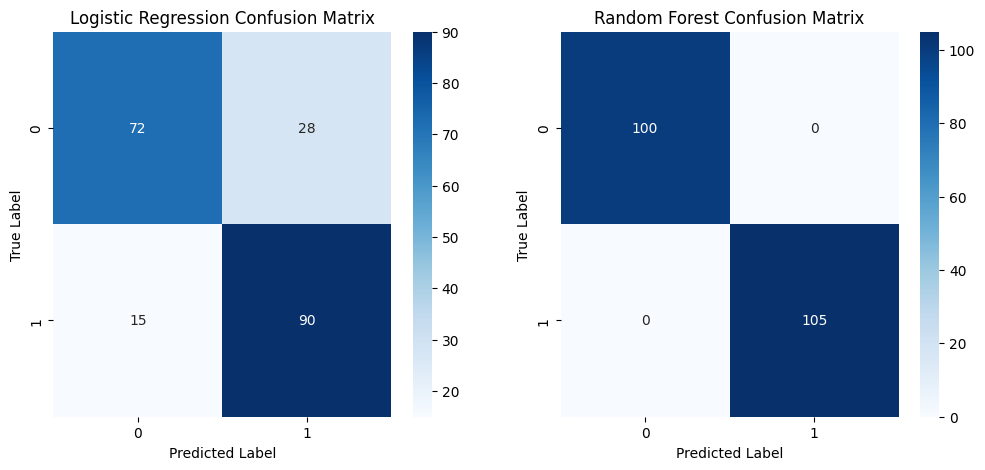

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

# Reload dataset
df = pd.read_csv("119 Heart.csv")

# Check class distribution
print("Class Distribution (Target):")
print(df["target"].value_counts(normalize=True))

#select initial features
initial_features = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak"]
X = df[initial_features]
y = df["target"]
#split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#logistic regression
log_reg = LogisticRegression(max_iter=500)
param_grid_log = {'C': [0.01, 0.1, 1, 10, 100]}
grid_log = GridSearchCV(log_reg, param_grid_log, cv=5, scoring='accuracy', n_jobs=-1)
grid_log.fit(X_train, y_train)
best_log_reg = grid_log.best_estimator_
#random forest
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

# Make predictions
y_pred_log = best_log_reg.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

# Compute accuracy and classification reports
acc_log = accuracy_score(y_test, y_pred_log)
acc_rf = accuracy_score(y_test, y_pred_rf)
report_log = classification_report(y_test, y_pred_log)
report_rf = classification_report(y_test, y_pred_rf)
cm_log = confusion_matrix(y_test, y_pred_log)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Print results
print("Logistic Regression Performance:")
print(f"Accuracy: {acc_log:.4f}")
print(report_log)
print("Random Forest Performance:")
print(f"Accuracy: {acc_rf:.4f}")
print(report_rf)

# Comparison table
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [acc_log, acc_rf]
})
print("Model Comparison:\n", comparison_df)

# Save the best model
with open("119model.pkl", "wb") as model_file:
    pickle.dump(best_rf, model_file)
print("Model saved as 119model.pkl")

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("Random Forest Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
plt.show()

PART 4: Feature Selection with RFECV and Model Retraining


Model successfully loaded.
Optimal Features Selected by RFECV: ['age', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak']
Model Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       499
           1       1.00      1.00      1.00       526

    accuracy                           1.00      1025
   macro avg       1.00      1.00      1.00      1025
weighted avg       1.00      1.00      1.00      1025



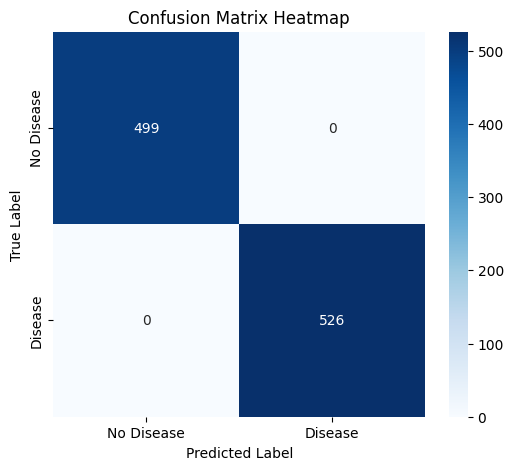

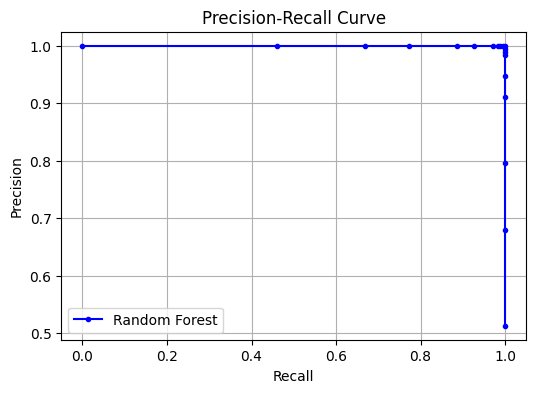

Updated model saved as 119model.pkl with optimized features.
scaler.pkl has been successfully created!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

#load the trained model
with open("119model.pkl", "rb") as model_file:
    model = pickle.load(model_file)
print("Model successfully loaded.")

df = pd.read_csv("119 Heart.csv")

#define initial features
initial_features = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak"]
X = df[initial_features]
y = df["target"]

#perform RFECV
rfecv = RFECV(estimator=RandomForestClassifier(random_state=42, class_weight="balanced"),
              step=1, cv=5, scoring="accuracy", n_jobs=-1)
rfecv.fit(X, y)
#get selected features
selected_features = [feature for feature, selected in zip(initial_features, rfecv.support_) if selected]
print("Optimal Features Selected by RFECV:", selected_features)
#prepare new feature set with selected features
X_new = df[selected_features]

#retrain the model with selected features
model_new = RandomForestClassifier(random_state=42, class_weight="balanced")
model_new.fit(X_new, y)
#make predictions
y_pred = model_new.predict(X_new)
#compute accuracy and classification report
accuracy = accuracy_score(y, y_pred)
report = classification_report(y, y_pred)
cm = confusion_matrix(y, y_pred)
#print result
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

#plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()
#plot precision-recall curve
precision, recall, _ = precision_recall_curve(y, model_new.predict_proba(X_new)[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.', color="blue", label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

#save the updated model
with open("119model.pkl", "wb") as model_file:
    pickle.dump(model_new, model_file)
print("Updated model saved as 119model.pkl with optimized features.")
#standardScaler on selected features
scaler = StandardScaler()
scaler.fit(X_new)  #fits scaler on the selected features only
with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)
print("scaler.pkl has been successfully created!")
#download the scaler file
from google.colab import files
files.download("scaler.pkl")



PART 5: Streamlit App


In [8]:
code = f"""
import streamlit as st
import pandas as pd
import numpy as np
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import logging

# Configure logging to save debugging information internally
logging.basicConfig(filename='debug.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s', filemode='a')

# Load trained model
with open("119model.pkl", "rb") as model_file:
    model = pickle.load(model_file)

# Load trained scaler
with open("scaler.pkl", "rb") as scaler_file:
    scaler = pickle.load(scaler_file)

# Load dataset
csv_path = "119 Heart.csv"
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
else:
    st.error("Error: '119 Heart.csv' not found. Please place it inside the same folder.")
    st.stop()

# Use the optimized feature list from RFECV (dynamically inserted from PART 4)
feature_columns = {selected_features}

# Log debugging information internally
logging.info("Features expected by model: %s", feature_columns)
logging.info("Number of features expected: %d", len(feature_columns))

# Streamlit UI
st.title("Heart Disease Prediction App")
st.subheader("Rohit Pradhan 31010922119")
st.write("Enter patient details below to predict heart disease.")

# Input fields aligned with selected features
inputs = {{}}
for feature in feature_columns:
    if feature == "age":
        inputs[feature] = st.number_input("Age", min_value=20, max_value=100, value=50)
    elif feature == "sex":
        inputs[feature] = st.selectbox("Sex (0 = Female, 1 = Male)", [0, 1])
    elif feature == "cp":
        inputs[feature] = st.number_input("Chest Pain Type (0-3)", min_value=0, max_value=3, value=1)
    elif feature == "trestbps":
        inputs[feature] = st.number_input("Resting Blood Pressure", min_value=80, max_value=200, value=120)
    elif feature == "chol":
        inputs[feature] = st.number_input("Cholesterol Level", min_value=100, max_value=600, value=200)
    elif feature == "fbs":
        inputs[feature] = st.selectbox("Fasting Blood Sugar (>120 mg/dl, 1 = Yes, 0 = No)", [0, 1])
    elif feature == "restecg":
        inputs[feature] = st.number_input("Resting ECG (0-2)", min_value=0, max_value=2, value=1)
    elif feature == "thalach":
        inputs[feature] = st.number_input("Max Heart Rate Achieved", min_value=60, max_value=220, value=150)
    elif feature == "exang":
        inputs[feature] = st.selectbox("Exercise Induced Angina (1 = Yes, 0 = No)", [0, 1])
    elif feature == "oldpeak":
        inputs[feature] = st.number_input("ST Depression", min_value=0.0, max_value=6.2, value=1.0)

# Predict button
if st.button("Predict"):
    # Create input data with the exact order and number of features as trained
    input_data = np.array([[inputs[feature] for feature in feature_columns]])

    # Scale input
    input_scaled = scaler.transform(input_data)

    # Make prediction
    prediction = model.predict(input_scaled)[0]

    st.subheader("Prediction Result")
    if prediction == 0:
        st.success("Low Risk (No Heart Disease)")
    else:
        st.error("High Risk (Potential Heart Disease)")

    # Model Performance
    if "target" in df.columns:
        y_true = df["target"]
        X_df = df[feature_columns]
        y_pred = model.predict(scaler.transform(X_df))

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        metrics_df = pd.DataFrame({{
            "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
            "Value": [accuracy, precision, recall, f1]
        }})
        st.subheader("Model Performance Metrics")
        st.table(metrics_df)

        # Confusion Matrix
        st.subheader("Confusion Matrix")
        cm = confusion_matrix(y_true, y_pred)
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"], ax=ax)
        st.pyplot(fig)

        # Class Distribution
        st.subheader("Class Distribution")
        class_counts = pd.Series(y_pred).value_counts().sort_index()
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis", ax=ax)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(["Low Risk", "High Risk"])
        ax.set_xlabel("Heart Disease Risk")
        ax.set_ylabel("Count")
        st.pyplot(fig)
"""

#save the file
with open("119app.py", "w") as file:
    file.write(code)
print("119app.py created")

#download the file
from google.colab import files
files.download("119app.py")

119app.py created


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>